<a href="https://colab.research.google.com/github/Ibsen-Gomes/Deep_learning_Colab/blob/main/Deep_learning_breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

### PyTorch package import:

In [2]:
import torch
torch.__version__

'2.0.1+cu118'

In [3]:
import torch.nn as nn

### Load data

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
previsores = pd.read_csv('/content/drive/MyDrive/Deep_learning/entradas_breast.csv')
classe = pd.read_csv('/content/drive/MyDrive/Deep_learning/saidas_breast.csv')



In [6]:
previsores.shape

(569, 30)

In [7]:
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [8]:
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


In [9]:
np.unique(classe)

array([0, 1])

### Sample count for each label:

<Axes: xlabel='0', ylabel='count'>

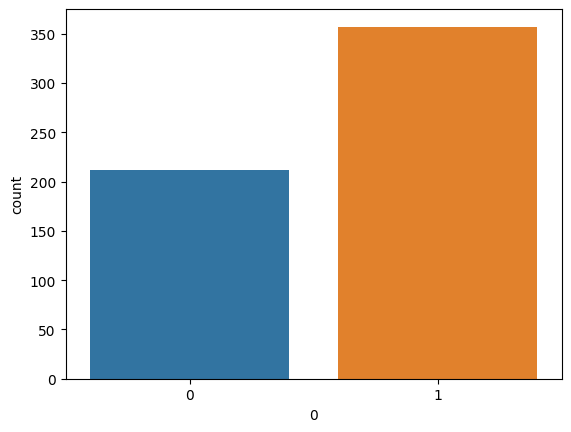

In [10]:
sns.countplot(x=classe['0'])

### Split data into training and testing:

In [11]:
previsores_train, previsores_test, classe_train, classe_test = train_test_split(previsores,
                                                                               classe,
                                                                               test_size = 0.25)

In [12]:
print(previsores_train.shape, classe_train.shape, previsores_test.shape, classe_test.shape) # check the shapes

(426, 30) (426, 1) (143, 30) (143, 1)


### Transformation into Tensors:

##### Essential for processing on GPUs

In [13]:
type(previsores_train)

pandas.core.frame.DataFrame

In [14]:
type(np.array(previsores_train))

numpy.ndarray

In [15]:
previsores_train = torch.tensor(np.array(previsores_train), dtype = torch.float)
classe_train = torch.tensor(np.array(classe_train), dtype = torch.float)

In [16]:
type(previsores_train)

torch.Tensor

In [17]:
type(classe_train)

torch.Tensor

#### Creation of a dataset with the union of predictors and classes:

In [18]:
dataset = torch.utils.data.TensorDataset(previsores_train, classe_train)

In [19]:
type(dataset)

torch.utils.data.dataset.TensorDataset

In [20]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

### Model building:

In [21]:
# 30 neurônios no input = 30 atributos previsores
# 16 neurônios 1° camada oculta
# 16 neurônios 2° camada oculta
# pq 16 neurônios nas redes ocultas? -> (entradas + saídas) / 2 = (30+1)/2 = 16
# 1 neurônio na camada de saída (probabilidade de uma classe 0 ou 1)

classificador = nn.Sequential( # sequencia de camada

    nn.Linear(in_features=30, out_features=16,), # Linear = todas as camadas de entrada ligado a todos de saída
    nn.ReLU(), # função de ativação aplicado no 1° camdada de 16 neurônios

    nn.Linear(16, 16), # Linear = todas as 16 camadas ligadas aos próximos 16 neurônios
    nn.ReLU(), # função de ativação aplicado no 2° camada de 16 neurônios

    nn.Linear(16, 1), # Linear = todas as 16 camadas ligadas ao neurônio de saída
    nn.Sigmoid(), # função de ativação na camada com 1 neurônio
)


In [22]:
# observar a estrutura da rede neural:

classificador.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [23]:
# Função de erro:

criterion = nn.BCELoss()
# Binary cross entropy (comparação entre previsão e gabarito)

In [24]:
# Otimizador

optimizer = torch.optim.Adam(classificador.parameters(),
                             lr = 0.001, # taxa de aprendizado
                             weight_decay = 0.0001) # decaimento dos pesos
                             # diminui lr com o passar das epocas

In [44]:
# Necessário um For para treinamento (diferente do TensorFLow ou Sklearn que tem um fit)
for epoch in range(200): # Em 1 epoca passando por 426 registros de 10 em 10 (batch) registros
  running_loss = 0. # Inicializar o acumulador do erro

  for data in train_loader: # train_loader = dados dividido em 10 em 10 registros

    inputs, labels = data # inputs=previsores e labels=classes
    optimizer.zero_grad() # zerar, pq em cada ajuste de peso é necessario calcular o gradiente separadamente

    outputs = classificador(inputs) #passando os inputs no modelo e gerando os outputs -> processo forward na rede (esqeurda p/ direita)
    # outputs-> classificador.forward(inputs)
    loss = criterion(outputs, labels) #calculo do erro entre labels reais e preditos
    loss.backward() #voltando e atualizando os pesos processo de backward na rede (direita p/ esquerda)
    optimizer.step() #atualização dos pesos usando o "Adam"

    running_loss += loss.item() #somatorio do erro
  print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))


Época   1: perda 0.16903
Época   2: perda 0.13317
Época   3: perda 0.14649
Época   4: perda 0.12645
Época   5: perda 0.12825
Época   6: perda 0.13072
Época   7: perda 0.13557
Época   8: perda 0.13752
Época   9: perda 0.12574
Época  10: perda 0.12867
Época  11: perda 0.13926
Época  12: perda 0.17216
Época  13: perda 0.21998
Época  14: perda 0.15726
Época  15: perda 0.18958
Época  16: perda 0.10270
Época  17: perda 0.13913
Época  18: perda 0.11765
Época  19: perda 0.11724
Época  20: perda 0.11082
Época  21: perda 0.11524
Época  22: perda 0.11435
Época  23: perda 0.12975
Época  24: perda 0.18454
Época  25: perda 0.11940
Época  26: perda 0.10665
Época  27: perda 0.11657
Época  28: perda 0.12813
Época  29: perda 0.11541
Época  30: perda 0.10819
Época  31: perda 0.10836
Época  32: perda 0.11920
Época  33: perda 0.11772
Época  34: perda 0.09690
Época  35: perda 0.16700
Época  36: perda 0.14758
Época  37: perda 0.10124
Época  38: perda 0.12282
Época  39: perda 0.22560
Época  40: perda 0.18721


### Visualization of weights:

In [45]:
params = list(classificador.parameters())


In [46]:
pesos0 = params[0]
pesos0.shape

torch.Size([16, 30])

In [47]:
# ligação (pesos) entre todas os 30 inputs da camadas de entrada com os 16 neurônios da primeira camada oculta
print(pesos0)

Parameter containing:
tensor([[-3.0252e-01,  1.9470e-01, -4.3069e-01,  6.3169e-02, -1.2455e-01,
          1.8700e-01, -2.0718e-01,  6.2858e-02,  1.0215e-01,  2.6136e-01,
          1.8225e-01,  2.6587e-02,  3.8213e-02,  2.0215e-01,  9.3089e-03,
          1.9209e-02,  9.7972e-02, -2.0351e-02,  6.4287e-01,  9.6996e-03,
         -5.3615e-01,  2.8192e-01, -3.6466e-01,  5.5116e-02, -3.0095e-01,
         -2.7347e-01, -4.2930e-01, -2.2039e-01, -2.4088e-01,  8.0924e-02],
        [-4.1443e-02, -4.4646e-02, -2.0202e-01, -2.8591e-03,  2.0464e-01,
          1.3739e-01,  1.0784e-01,  1.0084e-01, -9.2251e-02, -2.6704e-02,
          1.2437e-01, -4.0202e-02,  3.2382e-02,  1.1058e-01,  1.3563e-02,
          1.2478e-01,  2.0430e-01, -2.6260e-02,  4.9277e-01,  1.3466e-01,
         -5.8327e-01,  3.1599e-01, -3.5713e-01,  1.8757e-01,  1.5667e-01,
          8.6591e-02,  8.2741e-02,  2.3554e-02,  1.5731e-01,  5.3442e-01],
        [ 9.5104e-02, -4.1855e-01,  2.3979e-01, -5.5596e-02, -2.5673e-01,
          3.11

In [48]:
# Unidade de bias na 1° camada oculta
bias0 = params[1]
bias0.shape

torch.Size([16])

In [49]:
# ligação (pesos) entre todas os 16 neurônios da primeira camada oculta com os 16 neurônios da segunda camada oculta.
pesos1 = params[2]
pesos1.shape

torch.Size([16, 16])

In [50]:
# Unidade de bias na 2° camada oculta
bias1 = params[3]
bias1.shape

torch.Size([16])

### Model evaluation:

In [51]:
classificador.eval() # .eval = significa que o classificador em modo avaliação


Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [52]:
type(previsores_test)

torch.Tensor

In [53]:
previsores_test = torch.tensor(np.array(previsores_test), dtype=torch.float)

In [54]:
type(previsores_test)

torch.Tensor

In [55]:
previsoes = classificador.forward(previsores_test) # passar pela rede neural em forward

In [56]:
# probabilidade entre 0 e 1
previsoes

tensor([[4.1128e-01],
        [2.0087e-06],
        [2.4451e-03],
        [1.0000e+00],
        [9.9834e-01],
        [9.4987e-06],
        [8.6155e-09],
        [6.6492e-01],
        [9.9991e-01],
        [9.9321e-01],
        [9.9932e-01],
        [2.2631e-01],
        [9.9985e-01],
        [3.6486e-01],
        [1.0000e+00],
        [9.7123e-01],
        [9.9891e-01],
        [9.9899e-01],
        [1.0000e+00],
        [5.2450e-06],
        [1.0885e-03],
        [9.7384e-01],
        [4.8028e-10],
        [9.9916e-01],
        [9.9536e-01],
        [9.9993e-01],
        [9.9934e-01],
        [1.0000e+00],
        [9.9162e-01],
        [3.1888e-04],
        [9.9989e-01],
        [9.9930e-01],
        [1.0000e+00],
        [7.1213e-01],
        [9.9678e-01],
        [9.9987e-01],
        [2.7229e-03],
        [9.7438e-01],
        [1.7525e-06],
        [5.4938e-01],
        [6.3619e-01],
        [3.4740e-03],
        [9.9991e-01],
        [9.8935e-01],
        [1.0000e+00],
        [9

In [57]:
# Limiar de classificação

previsoes = np.array(previsoes> 0.5) # valor 0.5 de acordo com o cenário
previsoes

array([[False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [

In [58]:
previsoes.shape

(143, 1)

In [59]:
classe_test

,0
204,1
70,0
131,0
431,1
540,1
...,...
89,1
199,0
411,1
18,0


In [60]:
# Taxa de acerto, comparação entre as etiquetas 0 e 1 com as str True e False:

taxa_acerto = accuracy_score(classe_test, previsoes)
taxa_acerto

0.9230769230769231

In [61]:
# Matrix de confusão:

matrix = confusion_matrix(classe_test, previsoes)
matrix

array([[46,  8],
       [ 3, 86]])

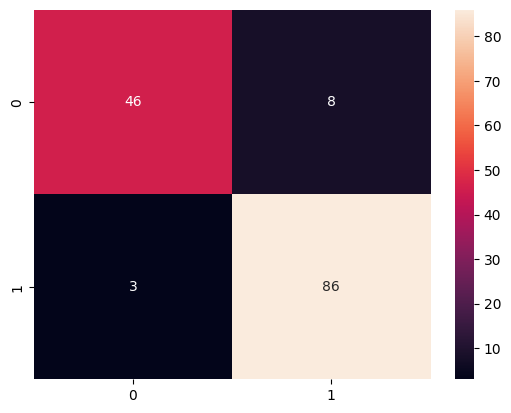

In [62]:
sns.heatmap(matrix, annot=True);